# Temporal Fusion Transformer Tutorial for Time Series Forecasting using Pytorch Lightning


Tutorial: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

Dataset: https://www.kaggle.com/datasets/utathya/future-volume-prediction

Context about the dataset: Country Beeristan, a high potential market, accounts for nearly 10% of Stallion's global beer sales. 

Stallion has a portfolio of products distributed to retailers through wholesalers. There are thousands of unique wholesalers SKU and product combinations. In order to plan its prooduction and distribution, and to help wholesalers with planner, it's important for Stallion to have an accurate estimate of demand at SKU level for each wholesaler.
 
Currently, demand is estimated by sale executives who just get a "feel" for the market and predict the new effect of forces of supply, demand, and other external factors based on their experience. 

The more experiences the sales excecutive is in a particular market, the better he performs. 

Joshua is the new Head of Sales and Operations Planning for Stallion, and he just took and analytics course. He realized he can do forecasting more effectively. 

Task: You are provided the following data: 
- price_sales_promotion.csv (units: dollars/hectoliter): this holds the sales data at Agency-SKU-month level from 1/2013 until 12/2017
- historical_volume.csv (units: hectoliters): holds the sales data at Agency-SKU-month level 
- weather.csv (units: degree celsius): holds average maximum temperature at Agnecy-month level 
- industry_soda_sales.csv (units: hectoliters): holds the industry level soda sales
- event_calendar.csv: holds even details (sports, carnivals, etc)
- industry_volume.csv (units: hectoliters): holds industry actual beer volume 
- demographics.csv: holds demographics details (yearly income in dollars) 

Test Data Formats: 
- volume_forecast.csv: you need to first forecast the demaind volume for January 2018 of all the agency-SKU combinations 
- sku_recommendations.csv: you need to suggest 2 SKUs which can be sold by Agency 06 and Agency 14. These two agencies are new and the company wants to find out which two products would be the best for the two agencies. 

In [1]:
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


import copy # enables copying python objects 
from pathlib import Path

import lightning.pytorch as pl # pytorch wrapper to handle model training 
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor 
from lightning.pytorch.loggers import TensorBoardLogger # training metrics for visualization
import numpy as np
import pandas as pd


import torch

# forecasting library built on pytorch lightning 
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
# Baseline: simple model to predict the mean or last observed value
# TemporalFusionTransformer(TFT): attention-based and gating model 
# TimeSeriesDataset: custom dataset object to prepare time series data for TFT or other models  - this handles encoding, scaling, and target shifting

from pytorch_forecasting.data import GroupNormalizer
# GroupNormalizer: normalizes data based on a group 

from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
# MAE: mean absolute error 
# SMAPE: symmetric mean absolute percentage error 
# PoissonLoss, QuantileLoss: loss functions tailored to count or quantile regressions tasks

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
#  uses Optuna to tune the hyperparameters of TFT 

In [3]:
from pytorch_forecasting.data.examples import get_stallion_data
data = get_stallion_data()

In [4]:
data

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,0,0,0,0,0,0,0,0,8.532566,0
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,0,0,0,0,0,0,0,0,13.000635,5
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,0,0,0,0,0,0,0,0,5.792496,9
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,...,0,0,0,0,0,0,0,0,7.940950,14
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,...,0,0,0,0,0,0,0,0,8.981168,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,Agency_08,SKU_03,9.8136,2017-12-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,0,0,0,0,0,0,0,0,14.717926,336
6764,Agency_60,SKU_05,2235.3495,2017-12-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,0,0,0,0,0,0,0,0,19.503372,188
6763,Agency_19,SKU_05,87.5430,2017-12-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,0,0,0,0,0,0,0,0,18.655677,162
6771,Agency_60,SKU_03,325.8792,2017-12-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,0,0,0,0,0,0,0,0,15.257220,187


In [5]:
# add time index
# converting the date column into the numeric time index 
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min() # normalizes the time index to avoid numerican instabilities or index confusion

# add additional features
data["month"] = data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8) # log transform the target variable to normalize skewed distributions and stabilize vairance. 1e-8 
data["avg_volume_by_sku"] = data.groupby(
    ["time_idx", "sku"], observed=True
).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(
    ["time_idx", "agency"], observed=True
).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = (
    data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
)
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [6]:
data.describe()

,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,21000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,2015-06-16 20:48:00,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
min,0.000000,2013-01-01 00:00:00,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,2014-03-24 06:00:00,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,2015-06-16 00:00:00,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,2016-09-08 12:00:00,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,2017-12-01 00:00:00,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375
std,2711.496882,NaN,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698


In [7]:
max_prediction_length = 6 # the length of the forecasting 
max_encoder_length = 24 # how much past data is used to create predictions
training_cutoff = data["time_idx"].max() - max_prediction_length


# https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length
    // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={
        "special_days": special_days
    },  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [8]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

# the Baseline model predicts the last predicted value in the sequence constantly. Your model should aim to beat this. 

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(293.0089, device='mps:0')

In [9]:
# configure network and trainer
pl.seed_everything(42) # https://pytorch-lightning.readthedocs.io/en/1.7.7/api/pytorch_lightning.utilities.seed.html


# https://lightning.ai/docs/pytorch/stable/common/trainer.html 
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

# from_dataset enables the configuration of i/o sizes from the dataset 
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(), # suitable for probabilistic forecasting 
    optimizer="ranger", # combines the RAdam+ Lookahead - this often leads to a fast convergence
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")


Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 13.5k


Finding best initial lr: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.041686938347033554
Restoring states from the checkpoint path at /Users/marilyn/Library/Mobile Documents/com~apple~CloudDocs/Documents/doctorate/ssdl/toy_datasets/transformer_stallion/.lr_find_4fddf033-9420-4523-8231-410809621aa7.ckpt
Restored all states from the checkpoint at /Users/marilyn/Library/Mobile Documents/com~apple~CloudDocs/Documents/doctorate/ssdl/toy_datasets/transformer_stallion/.lr_find_4fddf033-9420-4523-8231-410809621aa7.ckpt


suggested learning rate: 0.041686938347033554


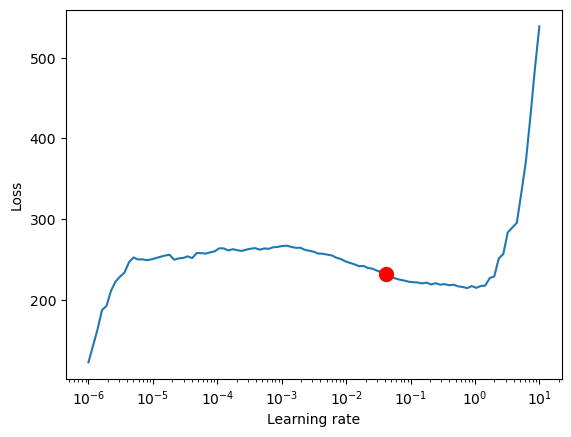

In [10]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

# learning rate tuning to choose an effective learning rate 
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [11]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10, # changed from 50 to 10
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.4k


In [12]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Epoch 9: 100%|██████████| 50/50 [01:18<00:00,  0.64it/s, v_num=6, train_loss_step=139.0, val_loss=201.0, train_loss_epoch=141.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [01:18<00:00,  0.64it/s, v_num=6, train_loss_step=139.0, val_loss=201.0, train_loss_epoch=141.0]


In [13]:
import pickle # module for serializing and saving objects

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [14]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=3,
    max_epochs=5,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-05-07 16:34:17,777] A new study created in memory with name: no-name-104ac93a-0179-4c5a-a0d5-3d713b549096
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2025-05-07 16:35:53,907] Trial 0 finished with value: 210.41262817382812 and parameters: {'gradient_clip_val': 0.11889126413281556, 'hidden_size': 34, 'dropout': 0.23773070275877464, 'hidden_continuous_size': 10, 'attention_head_size': 1, 'learning_rate': 0.07930873150854977}. Best is trial 0 with value: 210.41262817382812.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2025-05-07 16:37:24,045] Trial 1 finished with value: 170.23330688476562 and parameters: {'gradient_clip_val': 0.014641300257535381, 'hidden_size': 31, 'dropout': 0.10175703774867134, 'hidden_continuous_size': 20, 'attention_head_

{'gradient_clip_val': 0.9980394217048191, 'hidden_size': 93, 'dropout': 0.13201475907381569, 'hidden_continuous_size': 47, 'attention_head_size': 1, 'learning_rate': 0.0020499398747066393}


https://www.reddit.com/r/pytorch/comments/1335lwu/pytorch_enable_mps_fallback_help/

In [15]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [17]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
MAE()(predictions.output, predictions.y)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(371.3936)

In [18]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


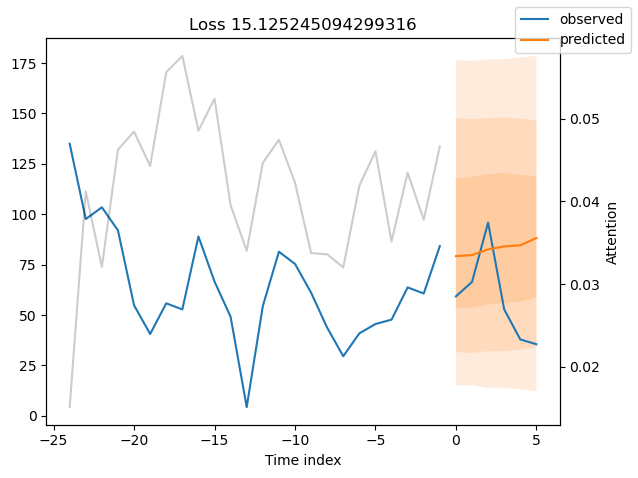

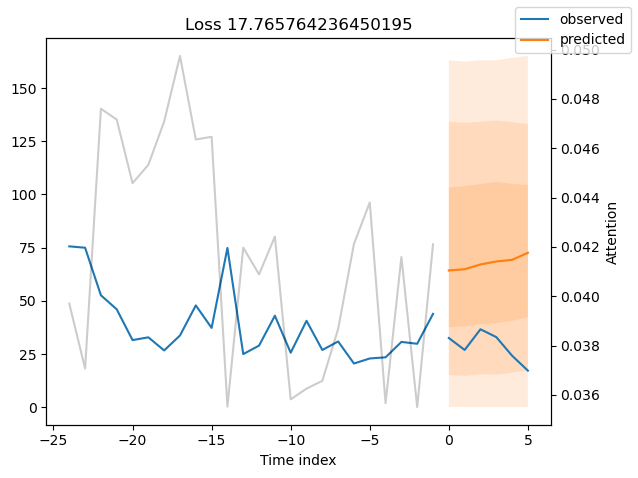

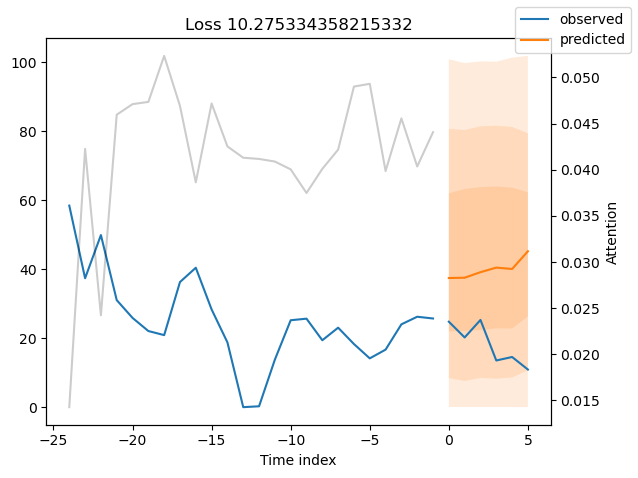

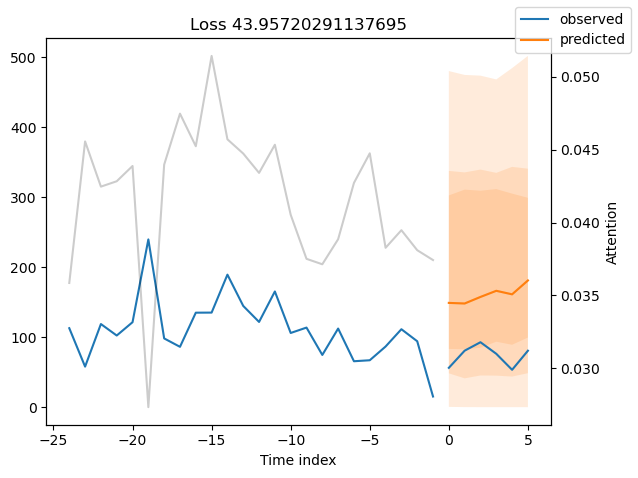

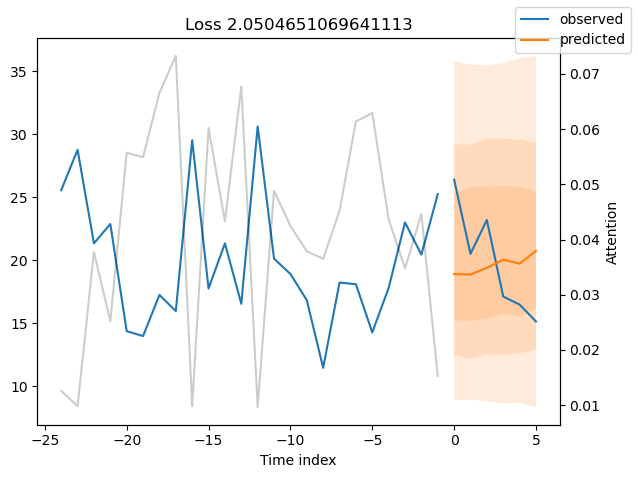

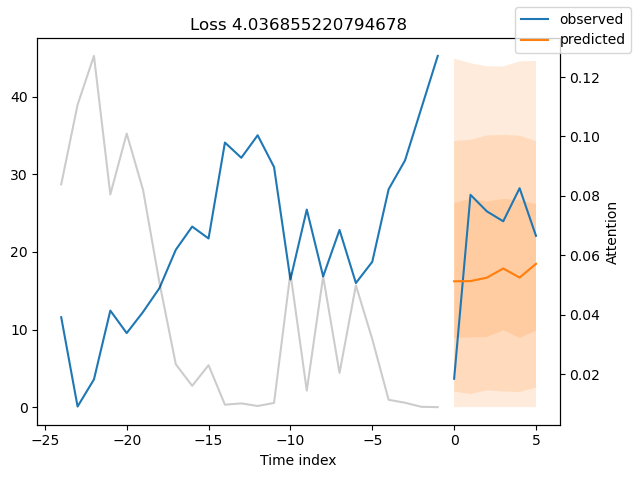

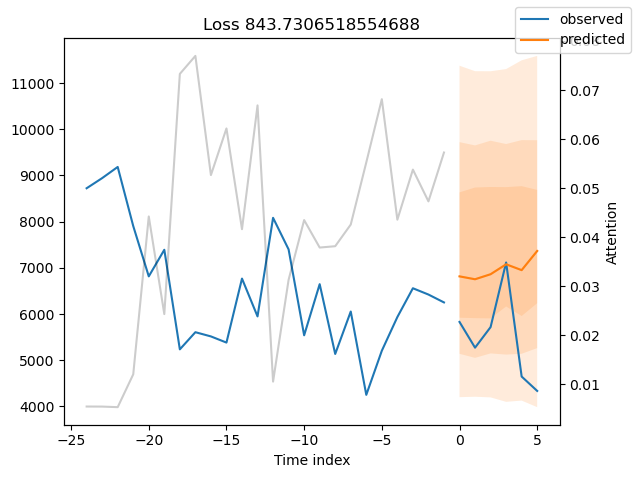

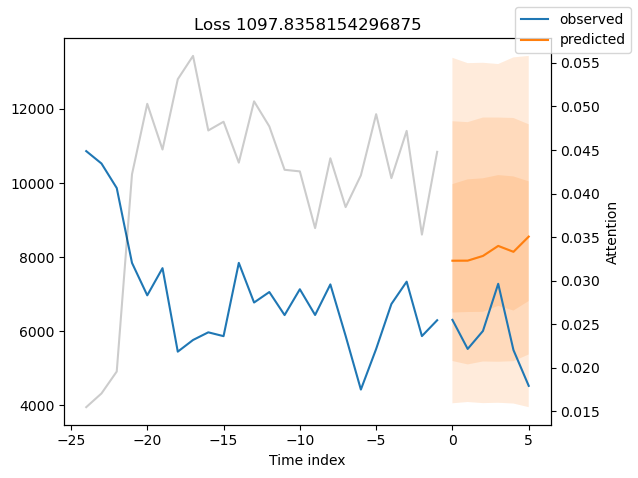

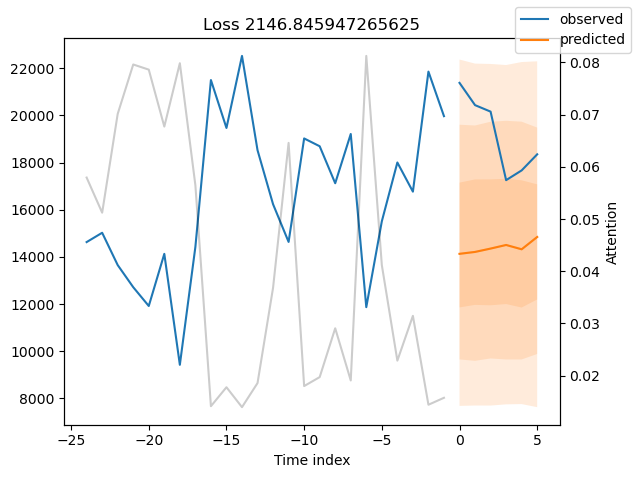

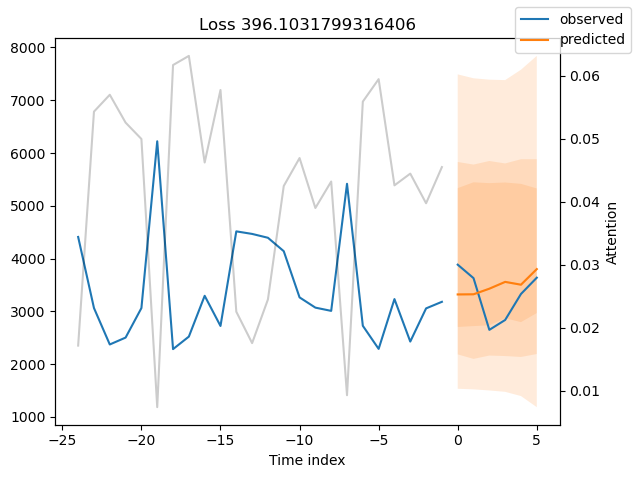

In [19]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


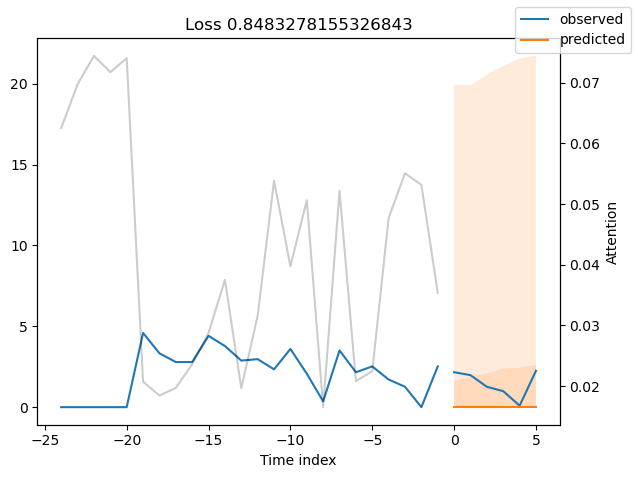

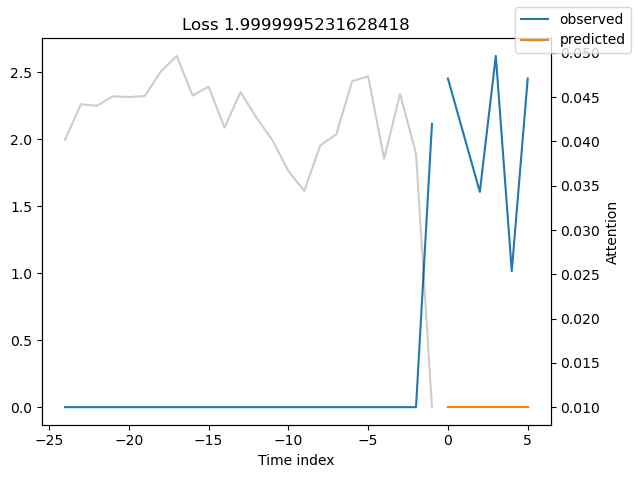

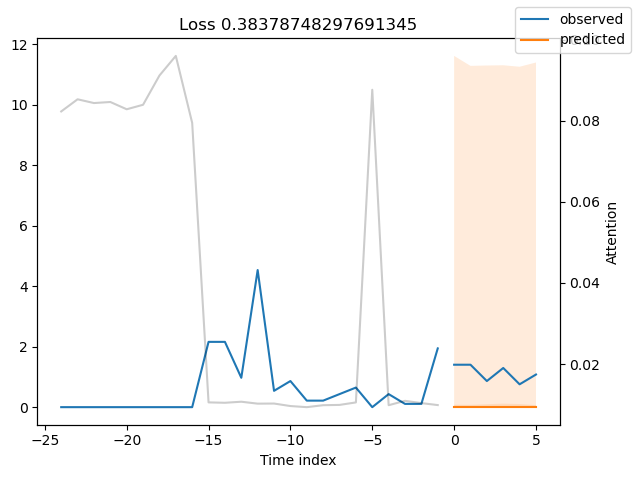

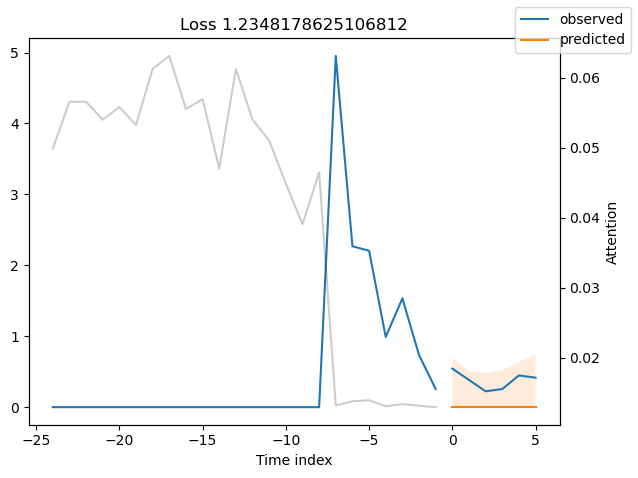

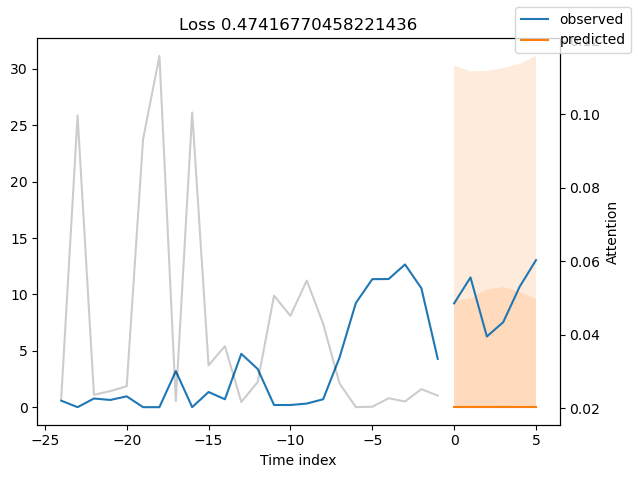

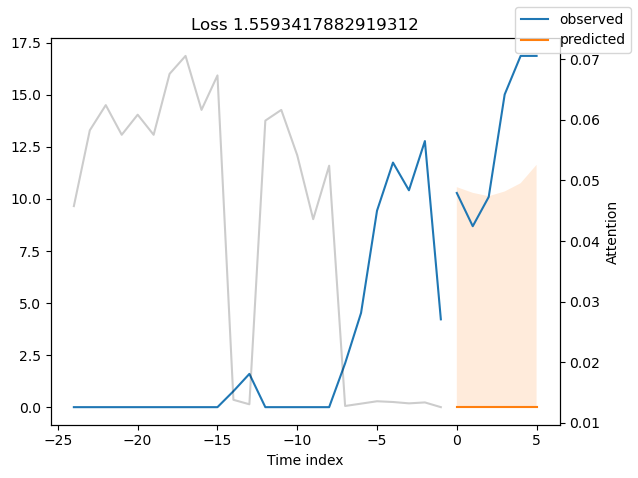

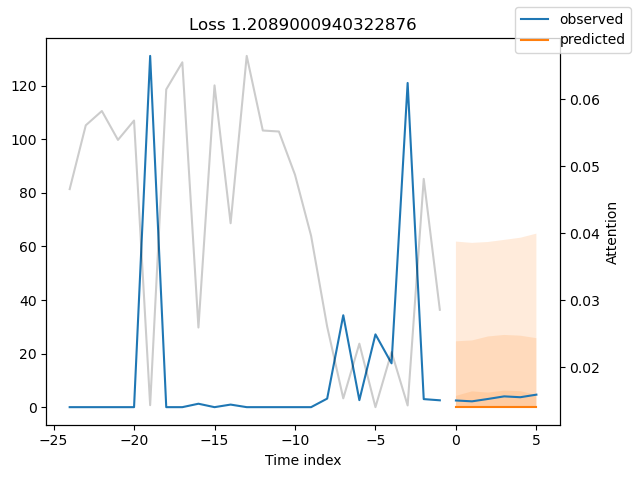

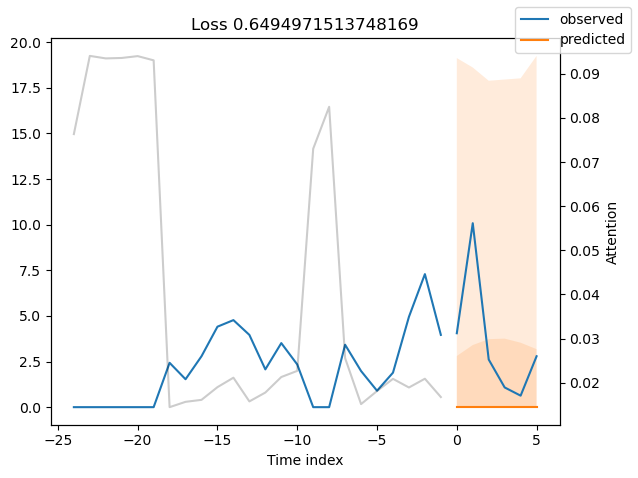

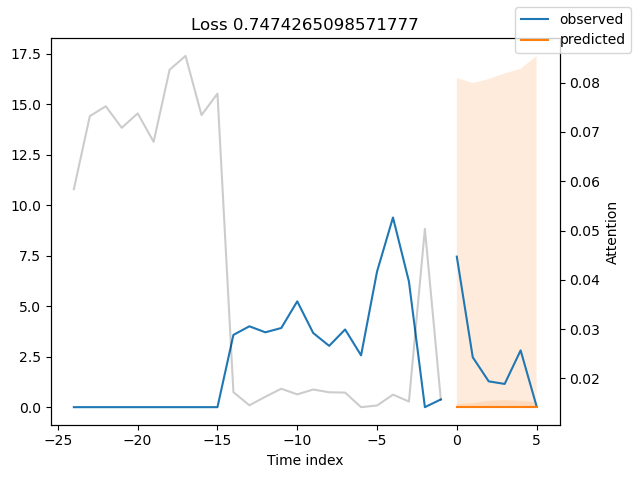

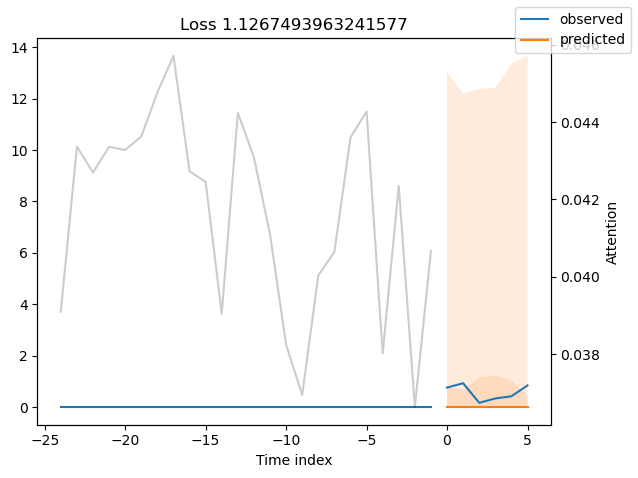

In [20]:
# calcualte metric by which to display
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
mean_losses = SMAPE(reduction="none").loss(predictions.output, predictions.y[0]).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'avg_population_2017': <Figure size 1000x500 with 2 Axes>,
 'avg_yearly_household_income_2017': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'volume_center': <Figure size 1000x500 with 2 Axes>,
 'volume_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'price_regular': <Figure size 1000x500 with 2 Axes>,
 'discount_in_percent': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'volume': <Figure size 1000x500 with 2 Axes>,
 'log_volume': <Figure size 1000x500 with 2 Axes>,
 'industry_volume': <Figure size 1000x500 with 2 Axes>,
 'soda_volume': <Figure size 1000x500 with 2 Axes>,
 'avg_max_temp': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_agency': <Figure size 1000x500 with 2 Axes>,
 'avg_volume_by_sku': <Figure size 1000x500 with 2 Axes>,
 'agency': <Figure size 1000x500 with 2 Axes>,
 'sku': <Figure size 1000x500 with 2 Axes>,
 'special_days'

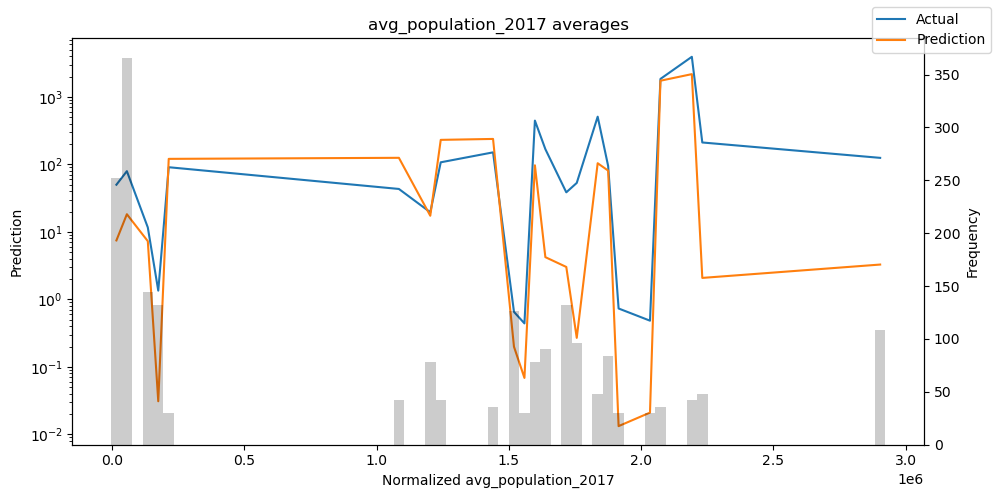

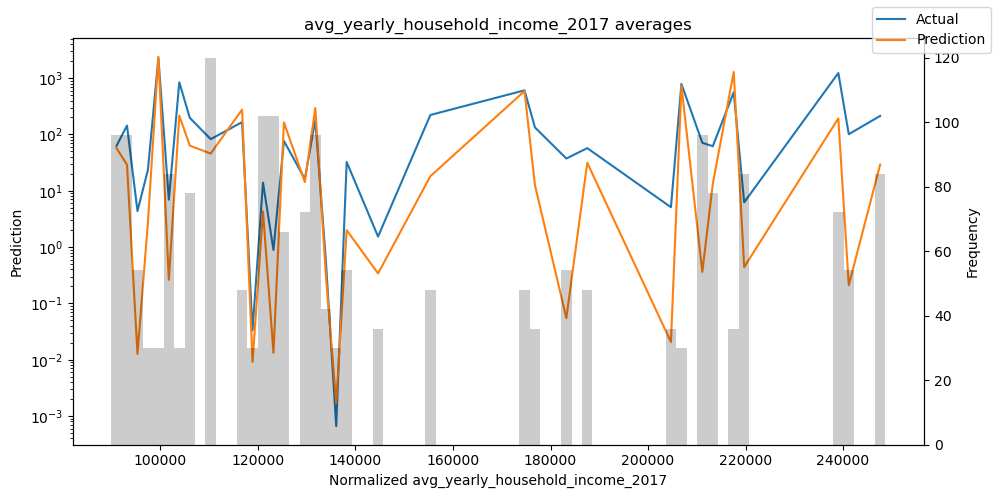

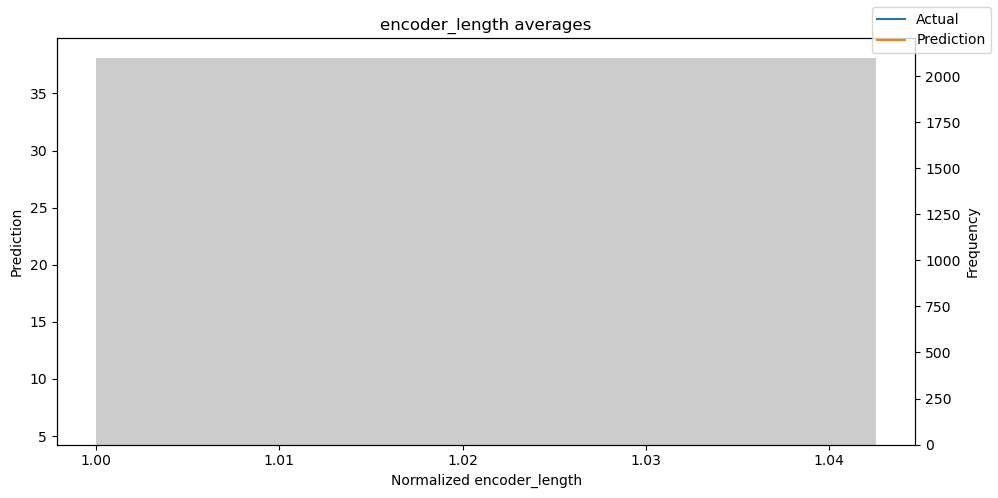

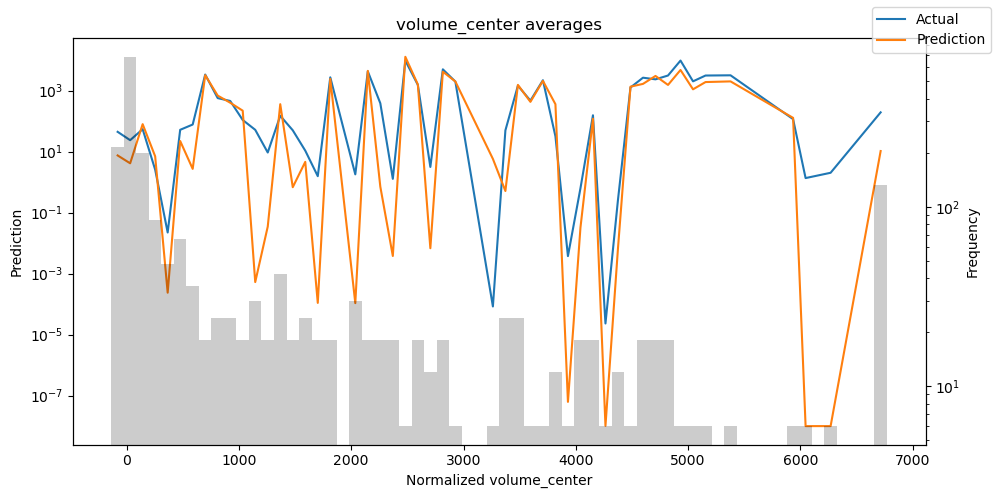

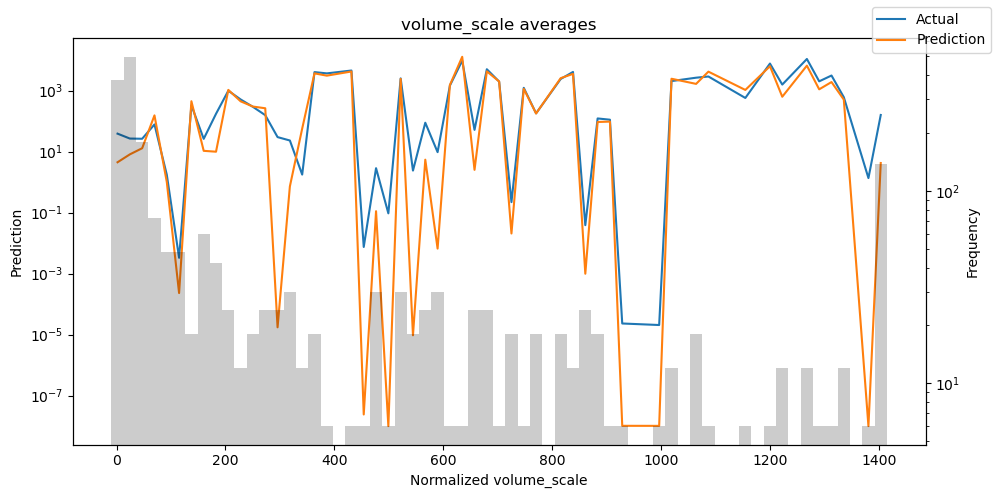

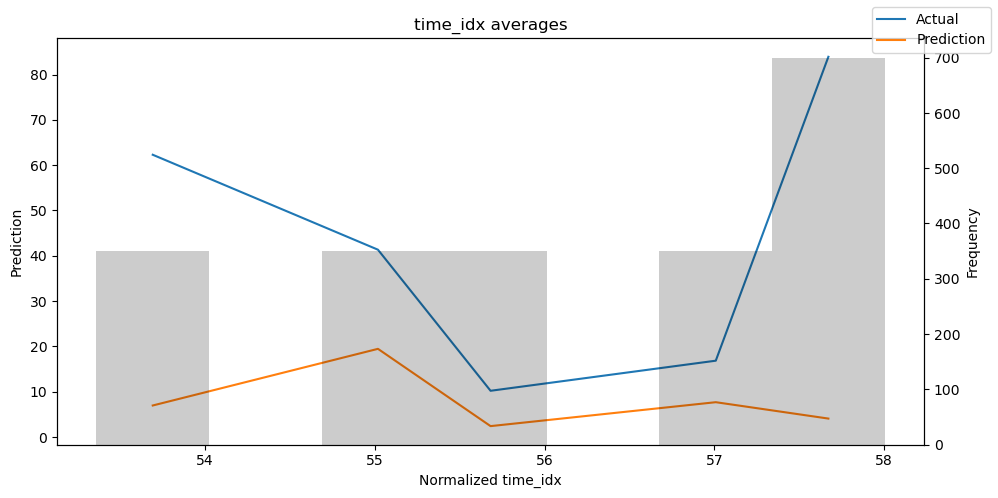

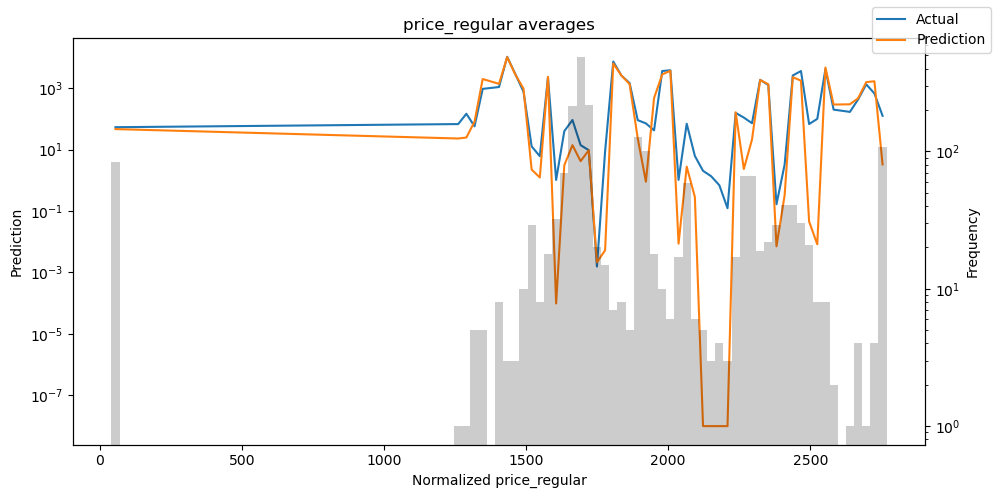

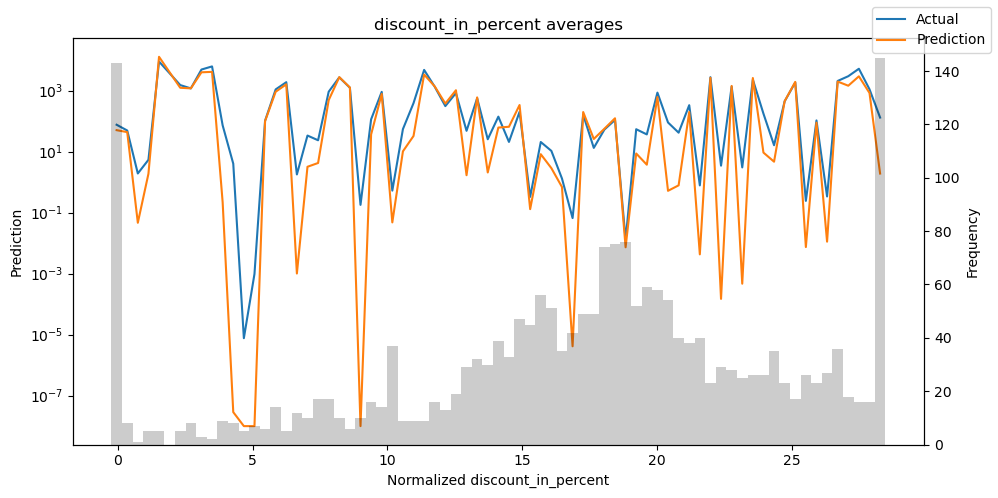

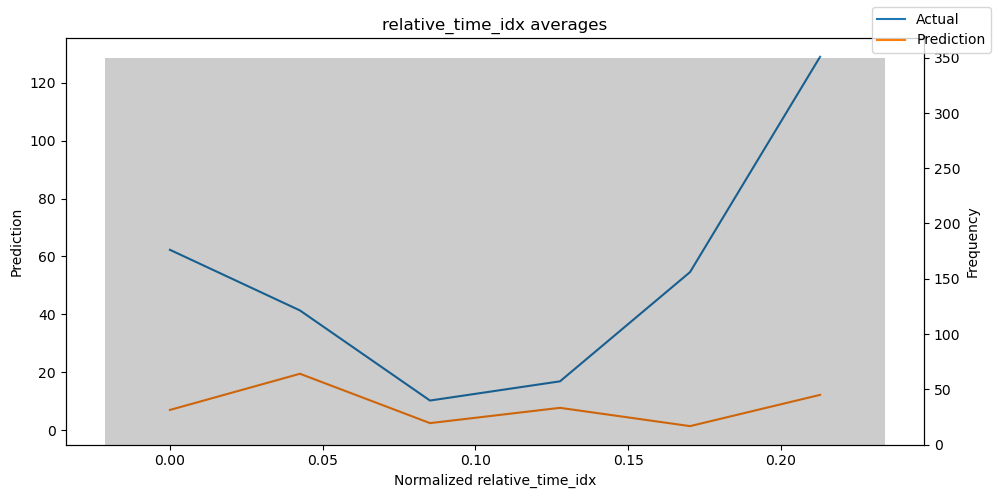

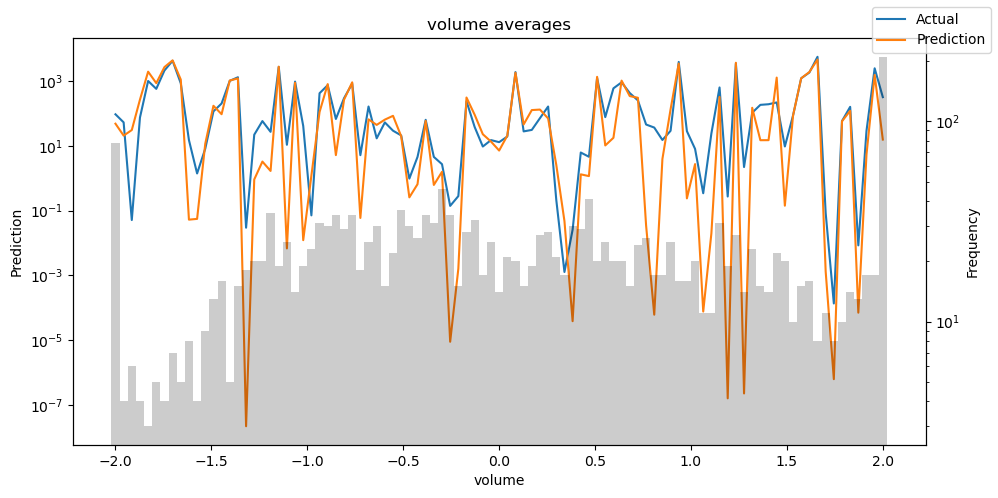

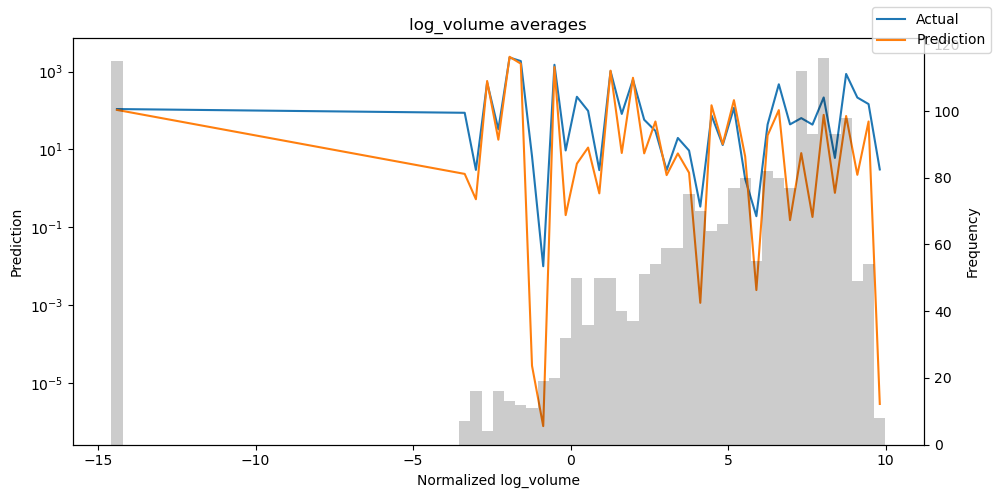

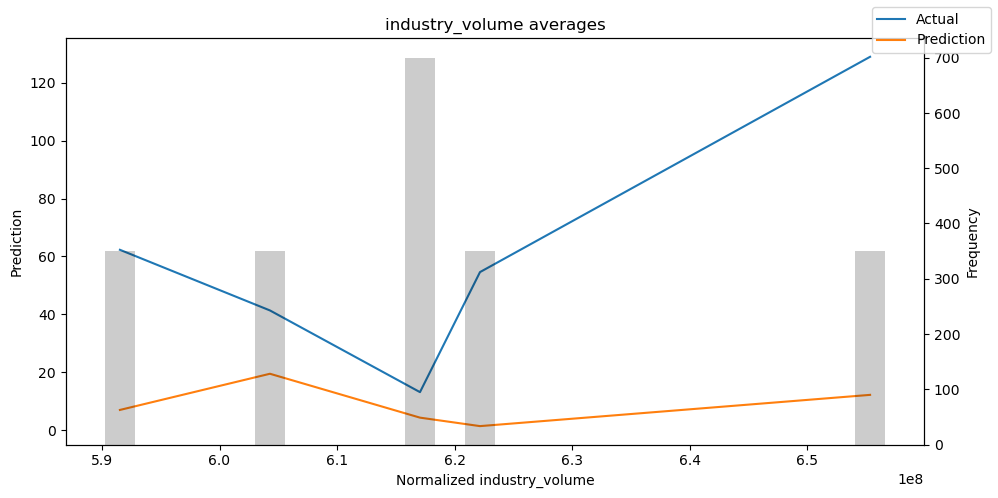

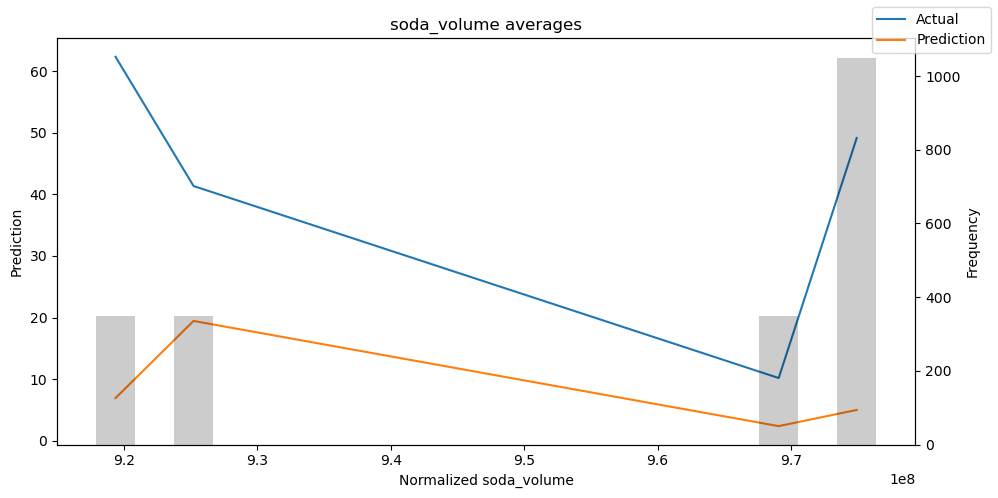

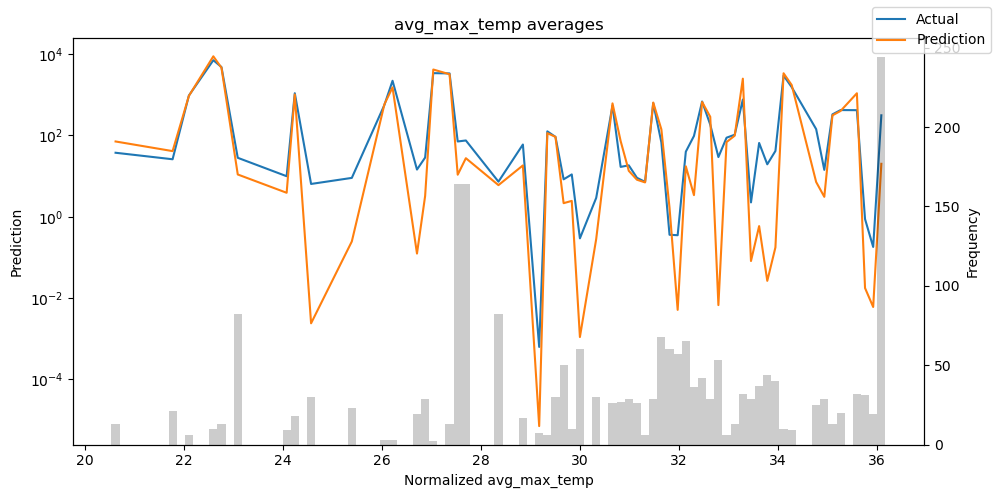

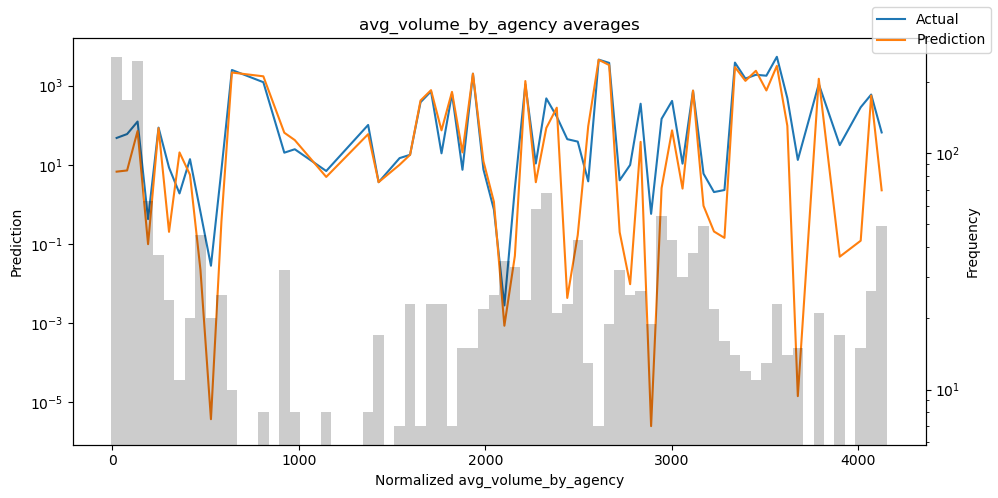

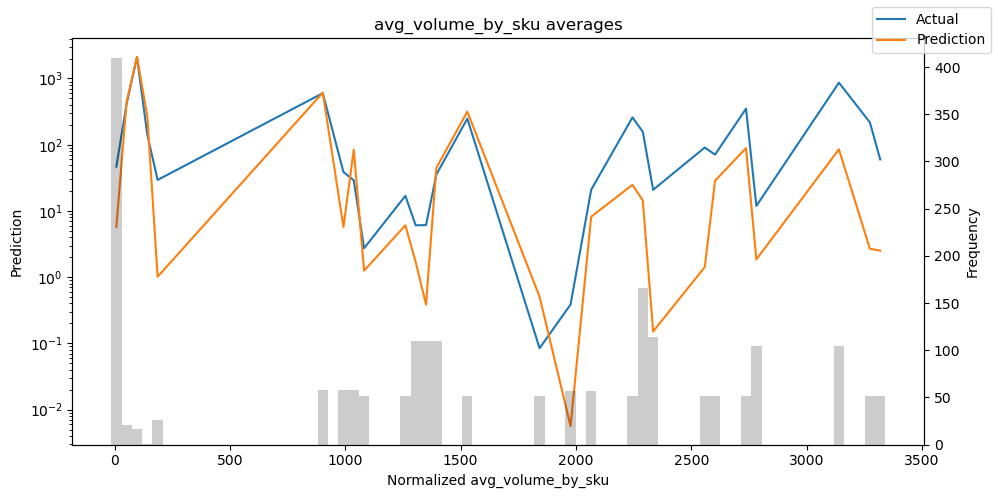

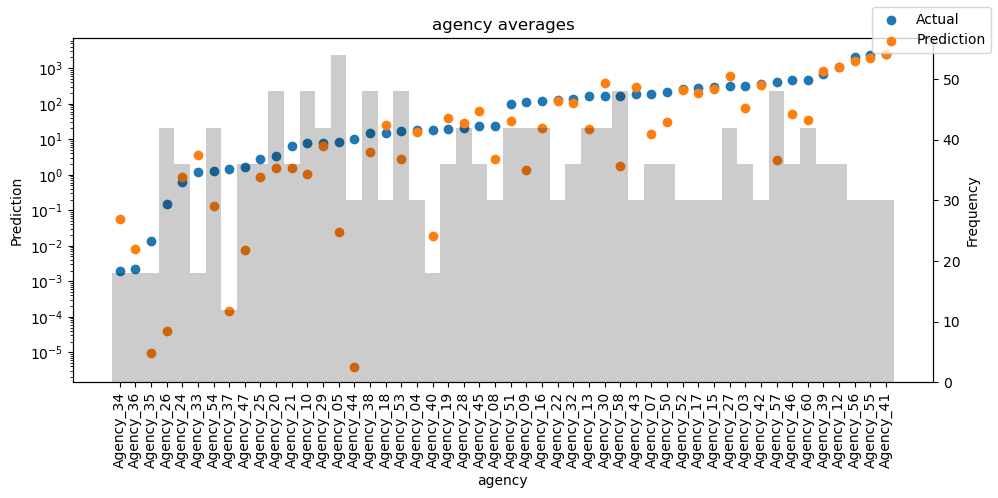

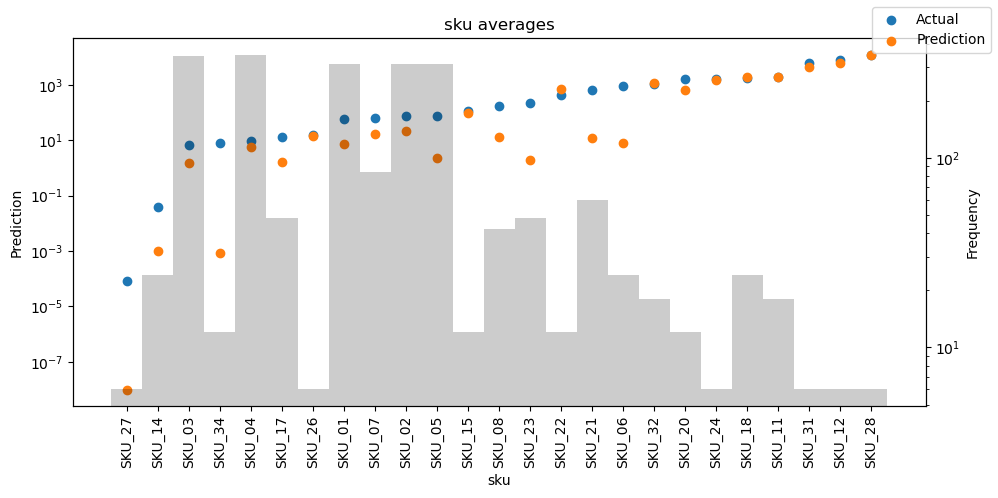

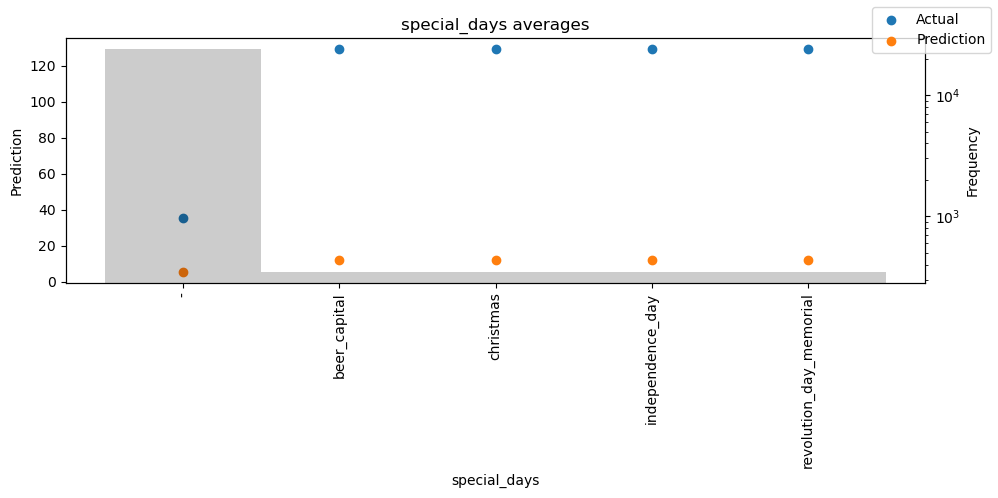

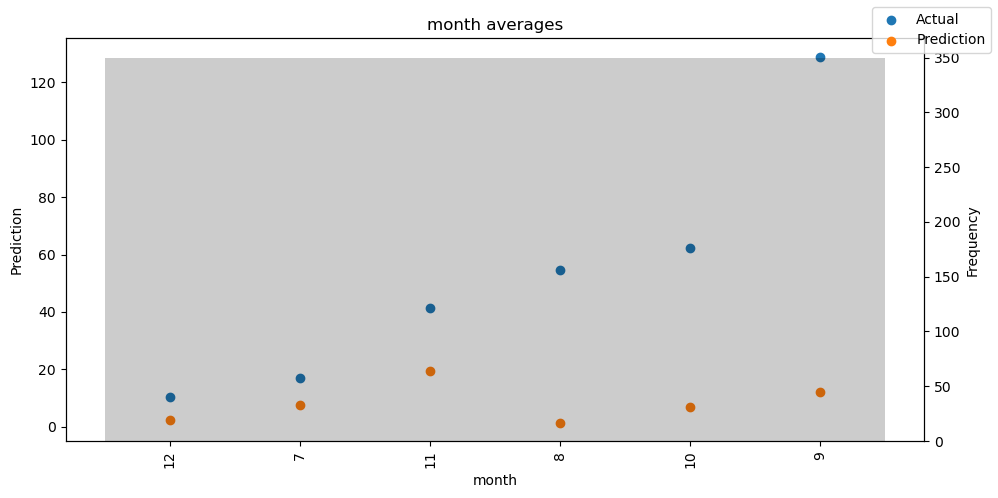

In [21]:
predictions = best_tft.predict(
    val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [22]:
best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="quantiles",
    trainer_kwargs=dict(accelerator="cpu"),
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor([[[ 15.9603,  37.7828,  58.9837,  84.8271, 108.4392, 140.8423, 177.1138],
         [ 18.0056,  38.1794,  58.7801,  85.7157, 107.1216, 142.6504, 173.6950],
         [ 17.1002,  38.5532,  59.6118,  86.4650, 107.8329, 142.8786, 173.8223],
         [ 17.0760,  38.8316,  59.4300,  86.6259, 107.9697, 142.7771, 174.0532],
         [ 16.3747,  38.0084,  59.6519,  86.8176, 109.8329, 142.6581, 174.2563],
         [ 16.0154,  38.2129,  59.3984,  87.2967, 109.7579, 142.9750, 174.9219]]])

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


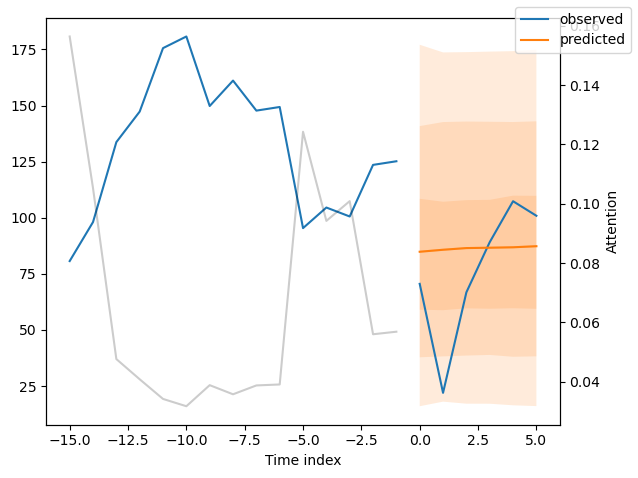

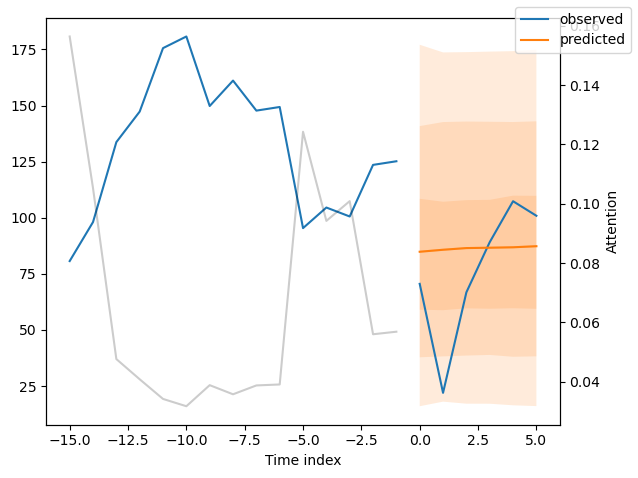

In [23]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [24]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [
        last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i))
        for i in range(1, max_prediction_length + 1)
    ],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (
    decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
)
decoder_data["time_idx"] += (
    encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
)

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


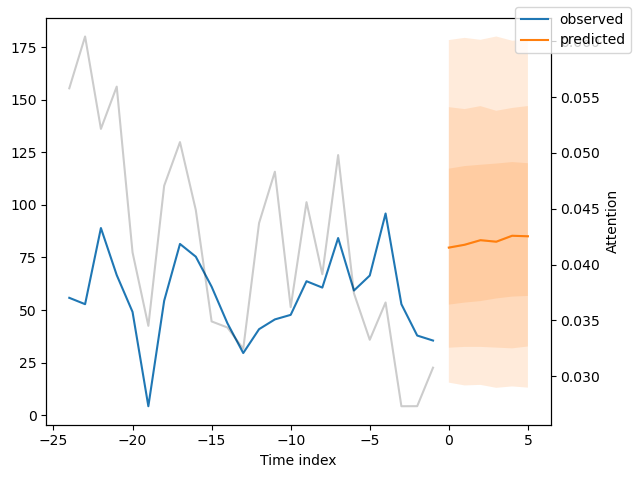

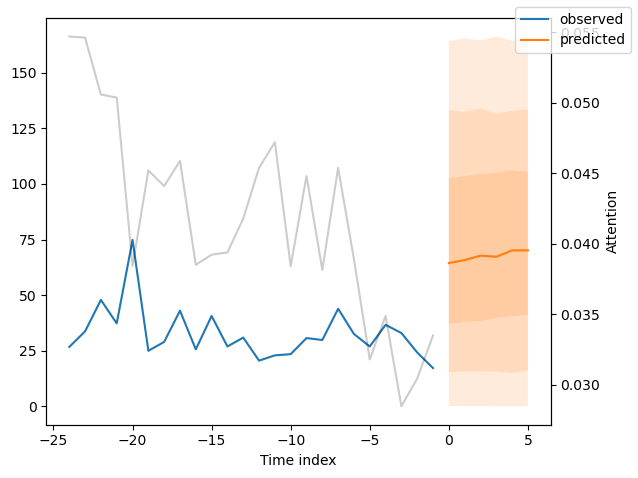

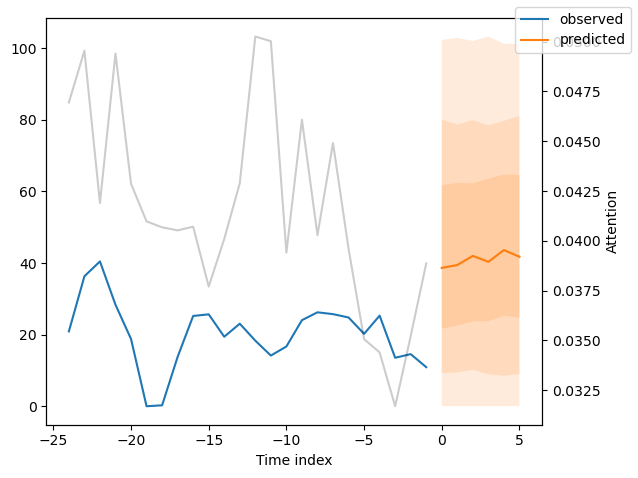

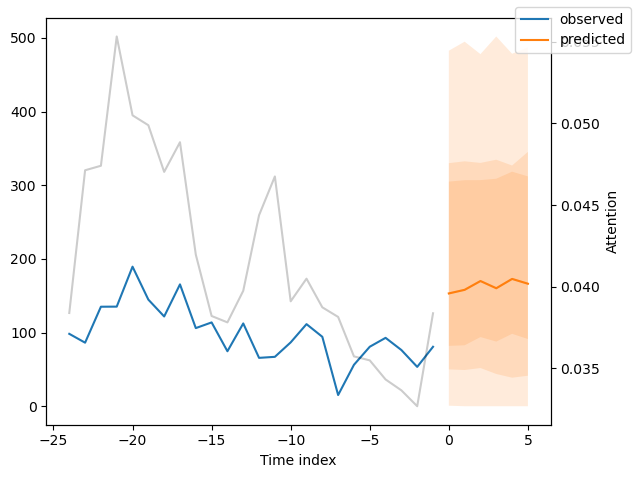

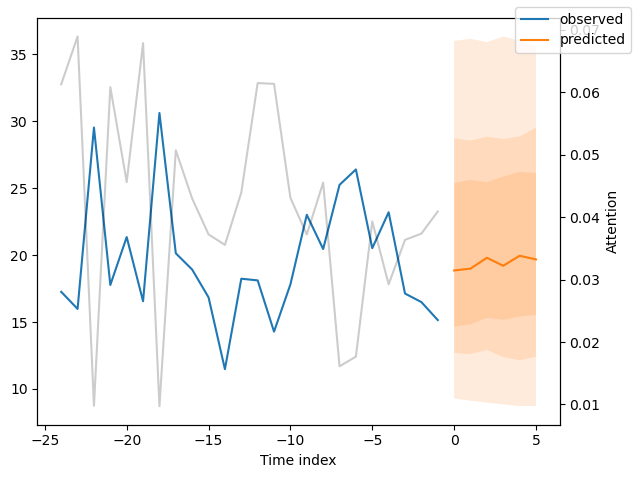

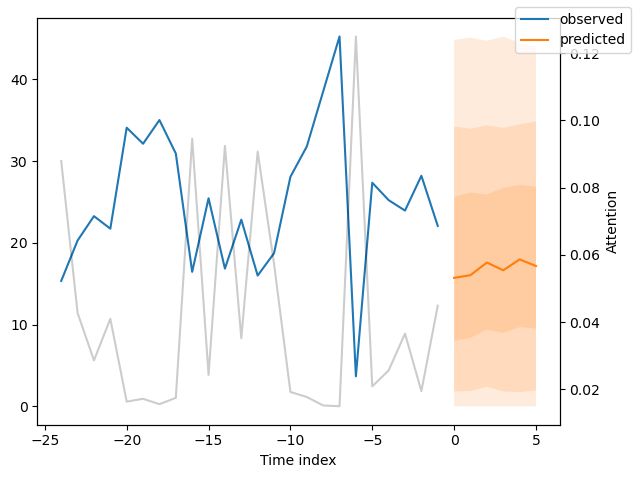

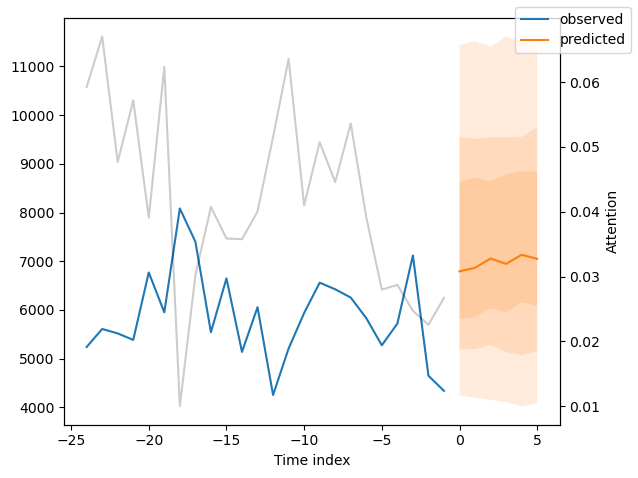

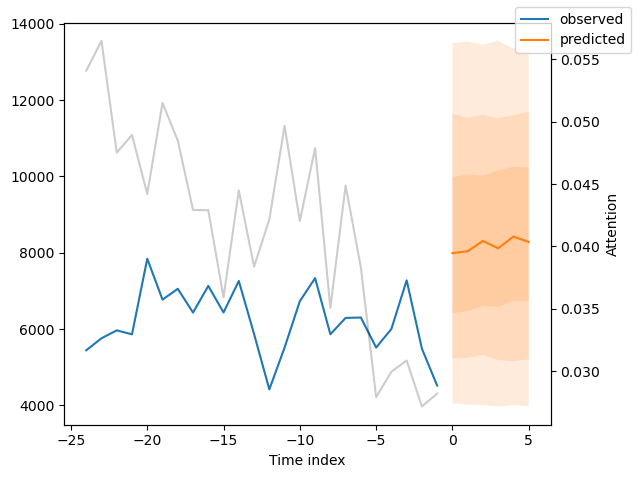

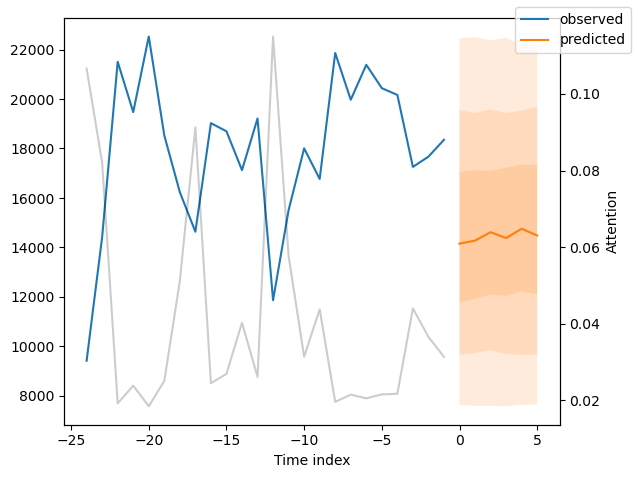

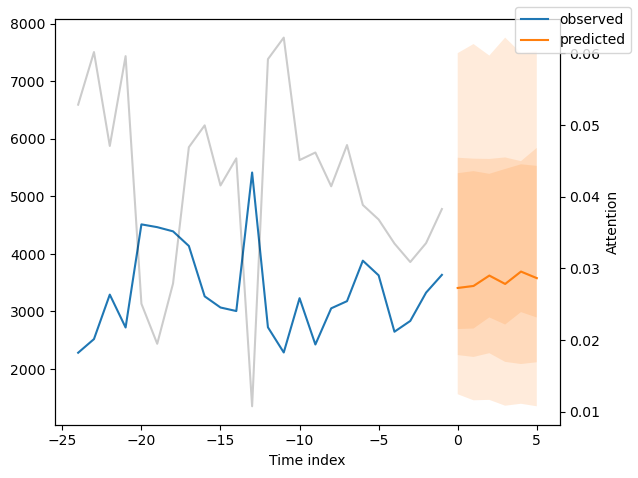

In [25]:
new_raw_predictions = best_tft.predict(
    new_prediction_data,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        new_raw_predictions.x,
        new_raw_predictions.output,
        idx=idx,
        show_future_observed=False,
    )

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x525 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

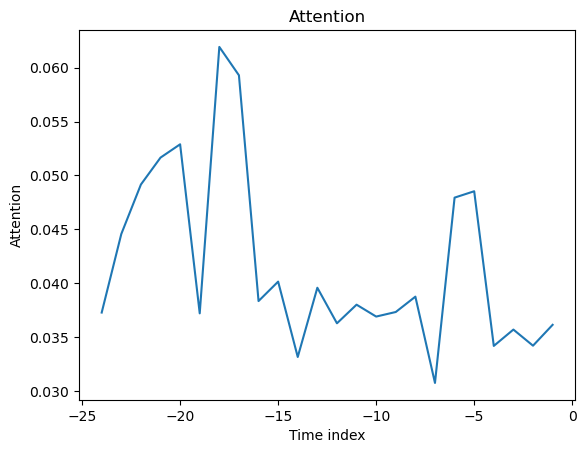

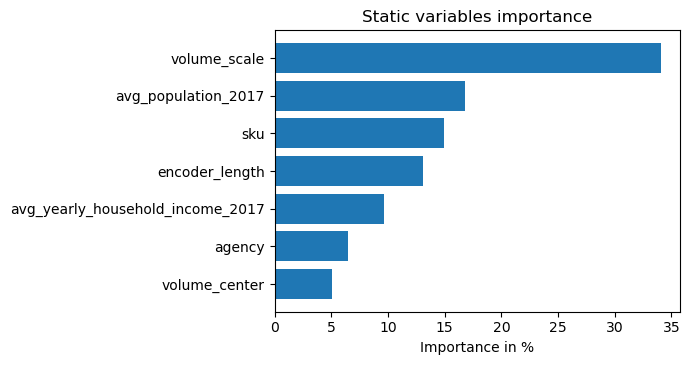

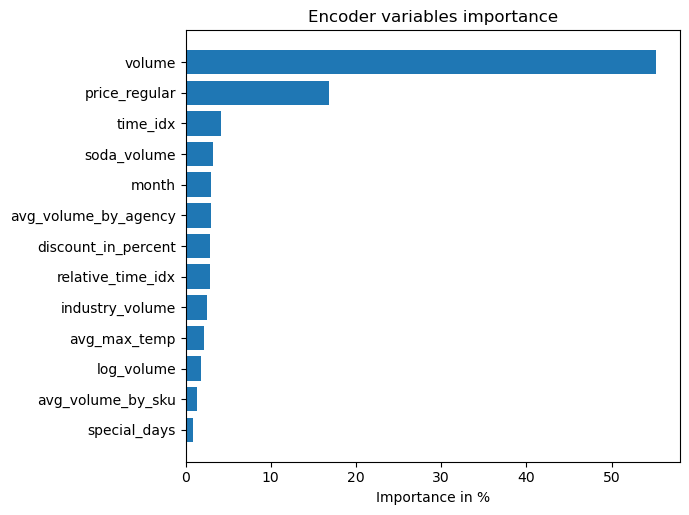

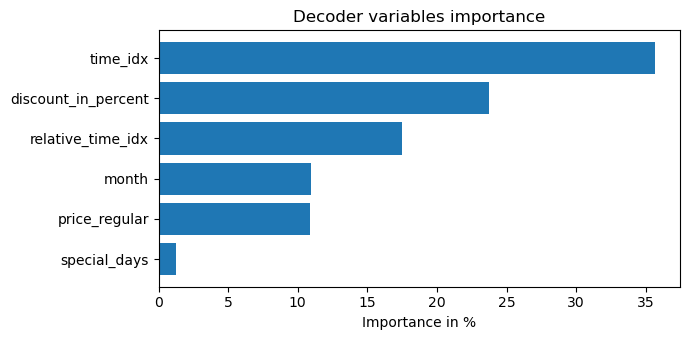

In [26]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [27]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset,
    "discount_in_percent",
    np.linspace(0, 30, 30),
    show_progress_bar=True,
    mode="dataframe",
    trainer_kwargs=dict(accelerator="cpu"),
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Predict:   3%|▎         | 1/30 [00:01<00:33,  1.16s/ batches]Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Predict:   7%|▋         | 2/30 [00:02<00:39,  1.41s/ batches]Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Pre

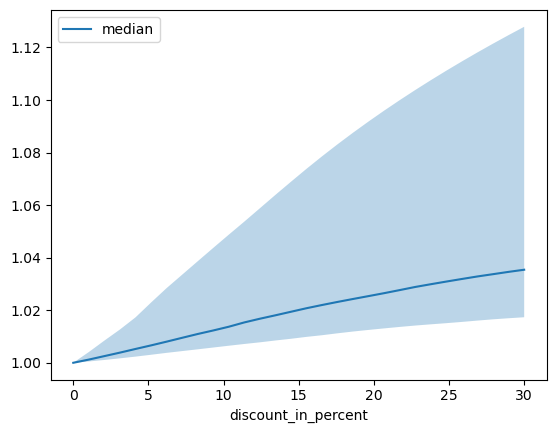

In [28]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)